In [146]:
import pybaseball
import numpy as np
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import pandas as pd
from sklearn.metrics import mean_squared_error

# Scaling values
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

def mean_absolute_error(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Evaluates model on test data
def fit_and_eval(model, model_type):    
    model.fit(X_train, y_train)
    
    model_pred = model.predict(X_test)

    model_mae = mean_absolute_error(y_test, model_pred)

    model_rmse = rmse(y_test, model_pred)
    
    tmp = pd.DataFrame({"True": y_test, "Pred": model_pred})
    
    sns.scatterplot(tmp,x="True", y="Pred").set_title(f"Comparing Prediction vs True for {model_type}")
    
    plt.show()
    
    return model_mae, model_rmse

# Return missing values by column
def missing_values(df):
        # Get all missing values
        missing_values = df.isnull().sum()
        
        # Returns total % that is missing
        missing_values_percent = 100 * df.isnull().sum() / len(df)
        
        missing_values_table = pd.concat([missing_values, missing_values_percent], axis=1)
        
        # Renaming the columns
        missing_values_table_rename_columns = missing_values_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total'})
        
        # Sort the table by percentage of missing descending
        missing_values_table_rename_columns = missing_values_table_rename_columns[
            missing_values_table_rename_columns.iloc[:,1] != 0].sort_values(
        '% of Total', ascending=False).round(1)
        print(missing_values_table_rename_columns)
        print ("Your DataFrame has " + str(df.shape[1]) + " columns.\n"      
            "It contains " + str(missing_values_table_rename_columns.shape[0]) +
              " columns with missing values.")
        
        # Return the df with missing info
        return missing_values_table_rename_columns

# Retrieve all statcast baseball data
all_data = pybaseball.batting_stats(2015, end_season=2022, qual=1)

training_data = all_data[all_data["Season"] < 2022]
target_data = all_data[all_data["Season"] > 2015]

In [147]:
missing_df = missing_values(training_data);
missing_columns = list(missing_df[missing_df['% of Total'] > 1].index)

             Missing Values  % of Total
xwOBA                  6500       100.0
PO%                    6500       100.0
xSLG                   6500       100.0
xBA                    6500       100.0
UN% (sc)               6500       100.0
...                     ...         ...
Swing% (pi)               5         0.1
Swing% (sc)               3         0.0
Barrels                   3         0.0
Zone% (sc)                3         0.0
HardHit                   3         0.0

[235 rows x 2 columns]
Your DataFrame has 320 columns.
It contains 235 columns with missing values.


In [148]:
training_data = training_data.drop(columns = list(missing_columns))
training_data = training_data.drop(['Name', 'Team', 'Dol',  'Age Rng'], axis=1)

In [149]:
training_data = training_data.dropna()
# Ensure training and testing data is same length
if len(training_data) > len(target_data):
    training_data = training_data.iloc[0:len(target_data)]
else:
    target_data = target_data.iloc[0:len(training_data)]

training_data = training_data.astype(float)

In [150]:
# Determining which features have the highest correlation to the target
# 80 is a lot of features to keep, but model did worse when features were reduced
tmp = data.copy()
tmp.rename(columns={'HR' : 'Old_Homers'}, inplace=True)
new_df = pd.merge(tmp, next_years_data[['HR','IDfg']], on='IDfg')
# correlations_data = abs(new_df.corr()['HR']).sort_values(ascending=False).drop("Old_Homers").head(10)
correlations_data = abs(new_df.corr()['HR']).sort_values(ascending=False)
# Show Pearson Coefficient Correlation values to determine how dependent the variables are on each other
print(correlations_data)
correlations_data = correlations_data.drop("Old_Homers").head(10)

HR             1.000000
Old_Homers     0.638922
Barrels        0.634656
RBI            0.613606
wRC            0.599562
                 ...   
Swing% (pi)    0.019363
Swing% (sc)    0.019323
BsR            0.016530
wSB            0.013220
Season         0.006768
Name: HR, Length: 103, dtype: float64


In [151]:
# Ensure features only has the relevant features
features = data[correlations_data.index].copy()
features = data.copy()
targets = pd.DataFrame(next_years_data['HR']).astype(float)
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

In [152]:
# Make scaler object with range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)

# Transform training and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [153]:
# Convert y to 1D array
y_train = np.array(y_train).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

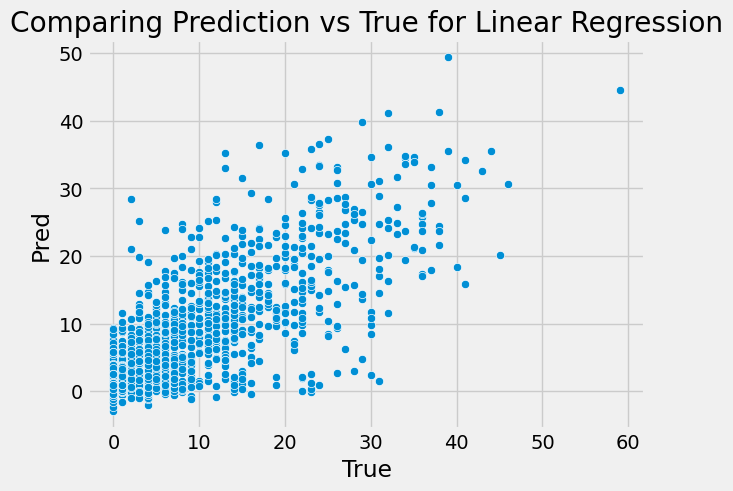

Linear Regression Performance on test set: MAE = 3.655842711142547
Linear Regression Performance on test set: RMSE = 5.518083522868137


In [154]:
lin_reg = LinearRegression()
lin_reg_mae, lin_reg_rmse = fit_and_eval(lr, "Linear Regression")

print(f'Linear Regression Performance on test set: MAE = {str(lin_reg_mae)}')
print(f'Linear Regression Performance on test set: RMSE = {str(lin_reg_rmse)}')

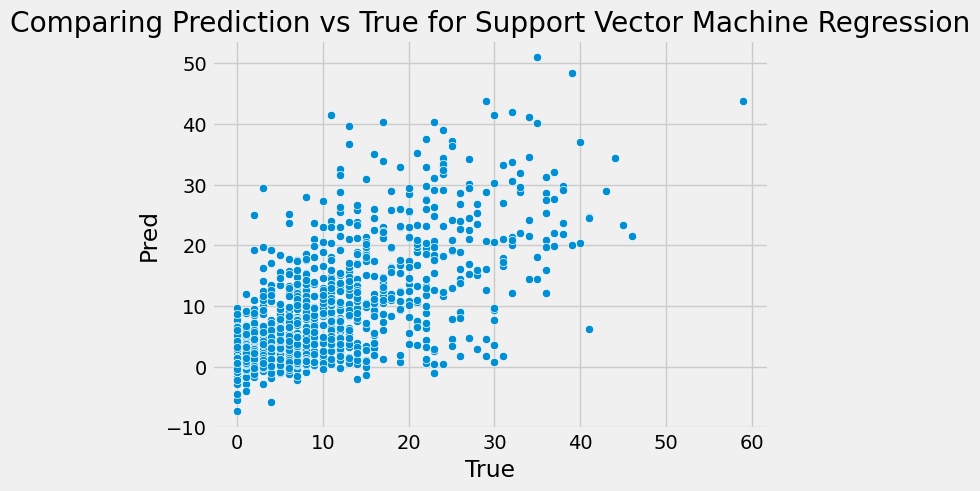

Support Vector Machine Regression Performance on test set: MAE = 3.594725940968963
Support Vector Machine Regression Performance on test set: RMSE = 6.01288928920299


In [155]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae, svm_rmse = fit_and_eval(svm, "Support Vector Machine Regression")
print(f'Support Vector Machine Regression Performance on test set: MAE = {str(svm_mae)}')
print(f'Support Vector Machine Regression Performance on test set: RMSE = {str(svm_rmse)}')

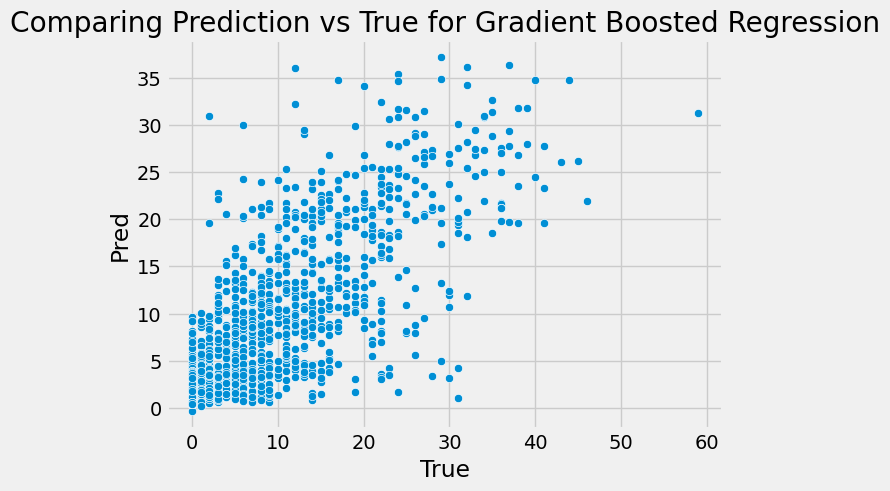

Gradient Boosted Regression Performance on test set: MAE = 3.32771935952644
Gradient Boosted Regression Performance on test set: RMSE = 5.28583728739956


In [156]:
grad_boost = GradientBoostingRegressor(random_state=100)
grad_boost_mae, grad_boost_rmse = fit_and_eval(grad_boost, "Gradient Boosted Regression")

print(f'Gradient Boosted Regression Performance on test set: MAE = {str(grad_boost_mae)}')
print(f'Gradient Boosted Regression Performance on test set: RMSE = {str(grad_boost_rmse)}')

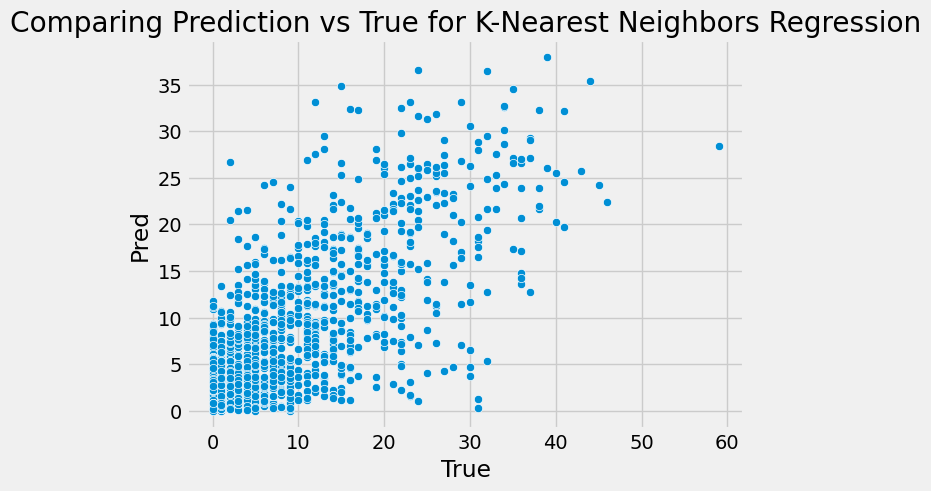

K-Nearest Neighbors Regression Performance on the test set: MAE = 3.662760834670947
K-Nearest Neighbors Regression Performance on test set: RMSE = 5.661483639801967


In [157]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae, knn_rmse = fit_and_eval(knn, "K-Nearest Neighbors Regression")

print(f'K-Nearest Neighbors Regression Performance on the test set: MAE = {str(knn_mae)}')
print(f'K-Nearest Neighbors Regression Performance on test set: RMSE = {str(knn_rmse)}')

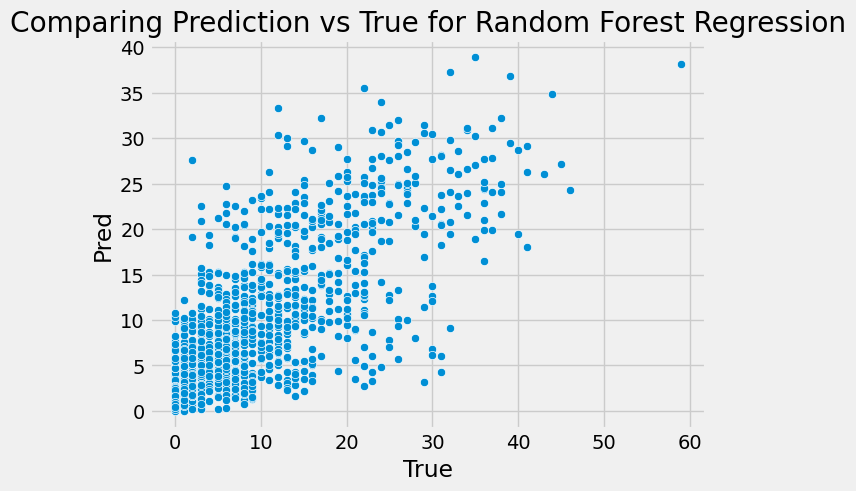

Random Forest Regression Performance on the test set: MAE = 3.2152755484216162
Random Forest Regression Performance on test set: RMSE = 5.191140820441736


In [158]:
random_forest = RandomForestRegressor(random_state=100)
random_forest_mae, random_forest_rmse = fit_and_eval(random_forest, "Random Forest Regression")

print(f'Random Forest Regression Performance on the test set: MAE = {str(random_forest_mae)}')
print(f'Random Forest Regression Performance on test set: RMSE = {str(random_forest_rmse)}')

<Figure size 800x600 with 0 Axes>

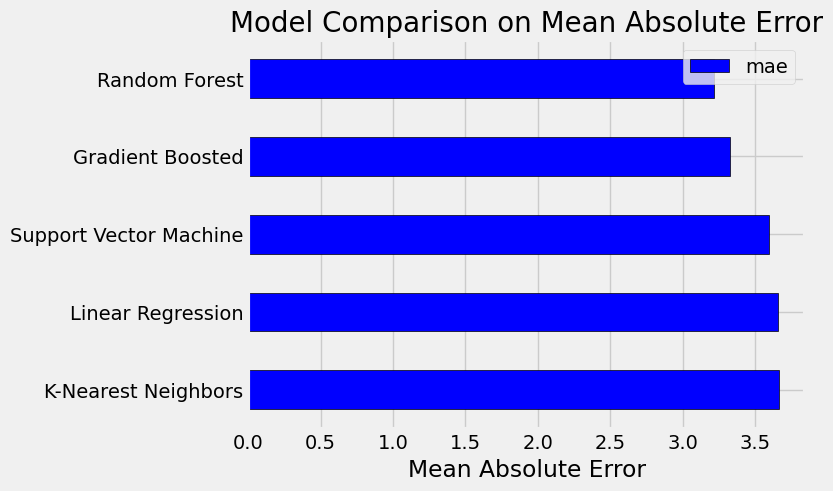

In [159]:
# Compare results of the model
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 6))

model_comparison_mae = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lin_reg_mae, svm_mae, random_forest_mae, 
                                         grad_boost_mae, knn_mae]})

# Bar chart of test mean absolute error
model_comparison_mae.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'blue', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); 
plt.yticks(size = 14); 
plt.xlabel('Mean Absolute Error'); 
plt.xticks(size = 14)
plt.title('Model Comparison on Mean Absolute Error', size = 20);

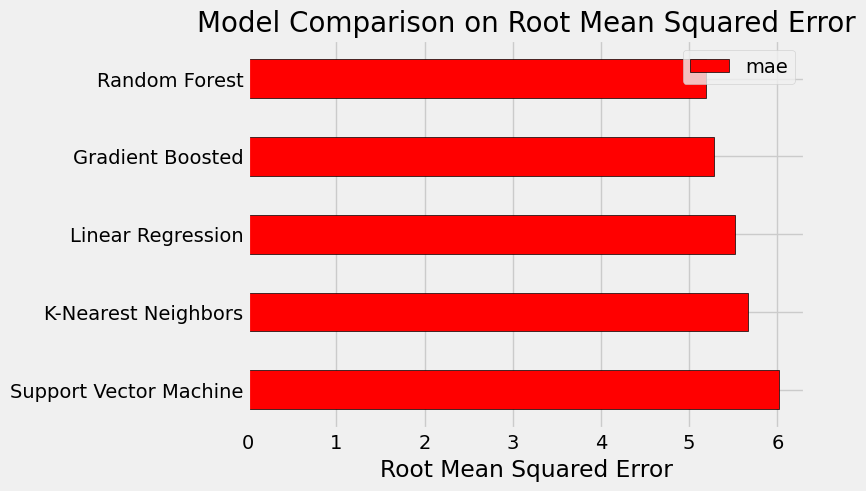

In [160]:
model_comparison_rmse = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lin_reg_rmse, svm_rmse, random_forest_rmse, 
                                         grad_boost_rmse, knn_rmse]})

# Bar chart of test mean absolute error
model_comparison_rmse.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); 
plt.yticks(size = 14); 
plt.xlabel('Root Mean Squared Error'); 
plt.xticks(size = 14)
plt.title('Model Comparison on Root Mean Squared Error', size = 20);

In [161]:
# function to measure the quality of a split
criterion = ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']

# Number of trees used in forest
n_estimators = [100, 500, 900, 1100, 1500]

# Max depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# The minimum number of samples required to split an internal node
min_samples_split = [2, 4, 6, 10]

#The number of features to consider when looking for the best split:
max_features = [1.0, 'sqrt', 'log2', None]

# Grid of hyperparameters to search
hyperparameter_grid = {'criterion':criterion,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [ ]:


# Random search with 5-fold cross validation
random_cv = RandomizedSearchCV(estimator=random_forest,
                               param_distributions=hyperparameter_grid,
                               cv=5, n_iter=20, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=100)
random_cv.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
# Get cv results and sort by the mean test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)


In [ ]:
# Show the best estimator's hyperparameters
random_cv.best_estimator_

In [ ]:
# Retain all but one of the best hyperparameter setting
# Toggle 'min_samples_leaf' to see how performance is impacted
leaf_grid = {'min_samples_leaf': [1, 2, 3, 4,5]}
model = RandomForestRegressor(max_depth = 5,
                                  min_samples_split = 10,
                                  n_estimators=900,
                                  max_features = None,
                                  random_state = 60,
                                  criterion='absolute_error')
grid_search = GridSearchCV(estimator = model, param_grid=leaf_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)
grid_search.fit(X_train, y_train)

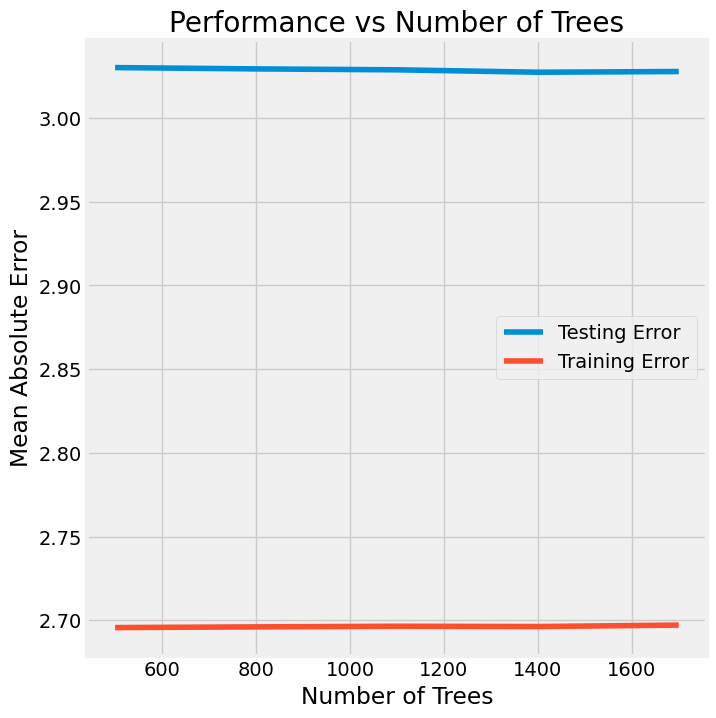

In [20]:
# Place results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot training and testing error v. # of trees
plt.figure(figsize=(8, 8))
plt.style.use('fivethirtyeight')
plt.plot(results['param_min_samples_leaf'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_min_samples_leaf'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Samples per Leaf Node'); 
plt.ylabel('Mean Absolute Error'); plt.legend();
plt.title('Performance vs Number of Samples per Leaf Node');

In [21]:
# Examine best results by mean test score
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
3,1547.558524,38.986075,0.062386,0.004877,1400,{'n_estimators': 1400},-3.042107,-2.976135,-3.144147,-2.947023,-3.027353,0.075721,1,-2.690549,-2.707726,-2.658559,-2.728060,-2.696224,0.025479
4,1757.426074,46.410478,0.069837,0.002258,1700,{'n_estimators': 1700},-3.043024,-2.976124,-3.144130,-2.947806,-3.027771,0.075554,2,-2.691726,-2.708257,-2.659534,-2.728846,-2.697091,0.025359
2,1269.045230,16.586536,0.057420,0.001367,1100,{'n_estimators': 1100},-3.045043,-2.977676,-3.143919,-2.948539,-3.028794,0.075119,3,-2.690873,-2.707685,-2.658834,-2.728194,-2.696396,0.025397
1,926.616186,10.518711,0.046189,0.002695,800,{'n_estimators': 800},-3.048323,-2.979431,-3.144995,-2.944581,-3.029333,0.076504,4,-2.690663,-2.706739,-2.658405,-2.728287,-2.696023,0.025493
0,581.616989,6.488197,0.029662,0.002158,500,{'n_estimators': 500},-3.050209,-2.977377,-3.149159,-2.943747,-3.030123,0.078765,5,-2.689249,-2.705826,-2.657760,-2.729566,-2.695600,0.026127


In [22]:
# Examine Default model vs our model

default_model = RandomForestRegressor(random_state = 100)

# Choose the best model
final_model = grid_search.best_estimator_

final_model



RandomForestRegressor(criterion='absolute_error', max_depth=5,
                      max_features=None, min_samples_leaf=2,
                      min_samples_split=10, n_estimators=1400, random_state=60)

In [23]:
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
3,1547.558524,38.986075,0.062386,0.004877,1400,{'n_estimators': 1400},-3.042107,-2.976135,-3.144147,-2.947023,-3.027353,0.075721,1,-2.690549,-2.707726,-2.658559,-2.728060,-2.696224,0.025479
4,1757.426074,46.410478,0.069837,0.002258,1700,{'n_estimators': 1700},-3.043024,-2.976124,-3.144130,-2.947806,-3.027771,0.075554,2,-2.691726,-2.708257,-2.659534,-2.728846,-2.697091,0.025359
2,1269.045230,16.586536,0.057420,0.001367,1100,{'n_estimators': 1100},-3.045043,-2.977676,-3.143919,-2.948539,-3.028794,0.075119,3,-2.690873,-2.707685,-2.658834,-2.728194,-2.696396,0.025397
1,926.616186,10.518711,0.046189,0.002695,800,{'n_estimators': 800},-3.048323,-2.979431,-3.144995,-2.944581,-3.029333,0.076504,4,-2.690663,-2.706739,-2.658405,-2.728287,-2.696023,0.025493
0,581.616989,6.488197,0.029662,0.002158,500,{'n_estimators': 500},-3.050209,-2.977377,-3.149159,-2.943747,-3.030123,0.078765,5,-2.689249,-2.705826,-2.657760,-2.729566,-2.695600,0.026127


In [25]:
# Create data frame to analyze feature importance
feature_results = pd.DataFrame({'feature': list(features.columns), 
                                'importance': final_model.feature_importances_})

# Let's see 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,RAR,0.526578
1,WAR,0.253469
2,L-WAR,0.096458
3,HR,0.012173
4,-WPA,0.006985
5,OPS,0.005718
6,R,0.004999
7,Barrels,0.003251
8,Def,0.002916
9,wRC+,0.002669
